In [1]:
import numpy as np
import pandas as pd
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import sys
from scipy import special, stats
from multiprocessing import get_context
from scipy import optimize

/home/sangrey/anaconda3/envs/volprice2/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

In [4]:
bounds = {'zeta1': {'max': 0, 'min':-35, 'dim':60}, 'phi': {'max': 0, 'min':-.59, 'dim':50}, 
          'zeta2': {'max':4, 'min': 0, 'dim':25}}
innov_dim = 2000

In [5]:
vl.__version__

'0.05.01-py37_0'

## Load the data

In [6]:
ll  -t -h ../data

lrwxrwxrwx 1 sangrey 46 Oct  8 12:45 ../data -> /home/sangrey/External/RiskPriceInferenceData//


In [7]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn_2017 = store['daily_rtn'] * 25.2 
    vol_2017 = store['discrete_vol_est'] * 25.2**2

with pd.HDFStore('../data/spy_daily_estimates_2017-2023_1000_15sec.hdf') as store:
    daily_rtn_2019 = store['daily_rtn'] * 25.2 
    vol_2019 = store['discrete_vol_est'] * 25.2**2

In [8]:
vol_2019.tail()

absolute  diffusion     jumps
0                                        
2023-06-26  2.793310   0.010969  0.011192
2023-06-27  2.189824   0.004159  0.010269
2023-06-28  2.831054   0.010063  0.014091
2023-06-29  2.512694   0.007204  0.012267
2023-06-30  2.117203   0.003217  0.010268

In [9]:
daily_rtn = pd.concat([daily_rtn_2017.to_frame(), 
                       daily_rtn_2019.loc[daily_rtn_2017.index.max() + pd.to_timedelta('1D'):]], axis=0)
vol = pd.concat([vol_2017, vol_2019.loc[vol_2017.index.max() + pd.to_timedelta('1D'):]], axis=0)
vol.index.name = daily_rtn.index.name

In [10]:
data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
data.columns = ['rtn', 'vol'] 

In [11]:
data.mean()

rtn    0.004463
vol    0.058242
dtype: float64

In [12]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

rtn       vol
rtn  0.070565 -0.004806
vol -0.004806  0.019283

In [13]:
data.corr()

rtn       vol
rtn  1.000000 -0.090481
vol -0.090481  1.000000

In [14]:
data.describe()

rtn          vol
count  5159.000000  5159.000000
mean      0.004463     0.058242
std       0.265641     0.143270
min      -3.116810     0.001233
25%      -0.100022     0.013920
50%       0.014012     0.025535
75%       0.121032     0.053926
max       2.280964     4.218808

In [15]:
data.describe()

rtn          vol
count  5159.000000  5159.000000
mean      0.004463     0.058242
std       0.265641     0.143270
min      -3.116810     0.001233
25%      -0.100022     0.013920
50%       0.014012     0.025535
75%       0.121032     0.053926
max       2.280964     4.218808

In [16]:
data_for_plot = data.copy()
data_for_plot.vol *= 252**2
data_for_plot.rtn *= 252

In [17]:
data_for_plot.mean()

rtn       1.124584
vol    3698.587740
dtype: float64

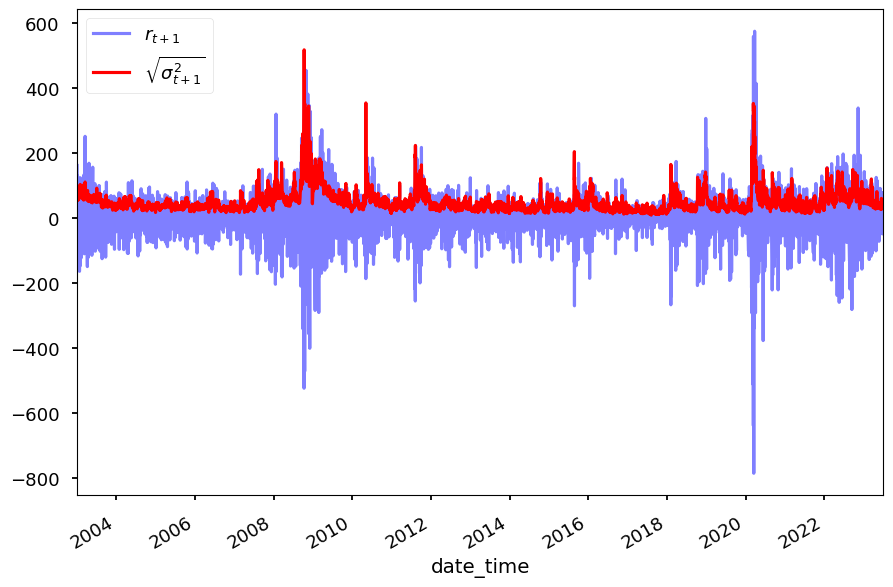

In [18]:
fig1, ax1 = mpl.pyplot.subplots()
data_for_plot['rtn'].plot(ax=ax1, color='blue', alpha=.5, label="$r_{t+1}$")
data_for_plot['vol'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{\sigma^2_{t+1}}$', color='red')
ax1.legend()
fig1.savefig('../doc/figures/time_series.tmp.png', pad_inches=0, bbox_inches='tight')

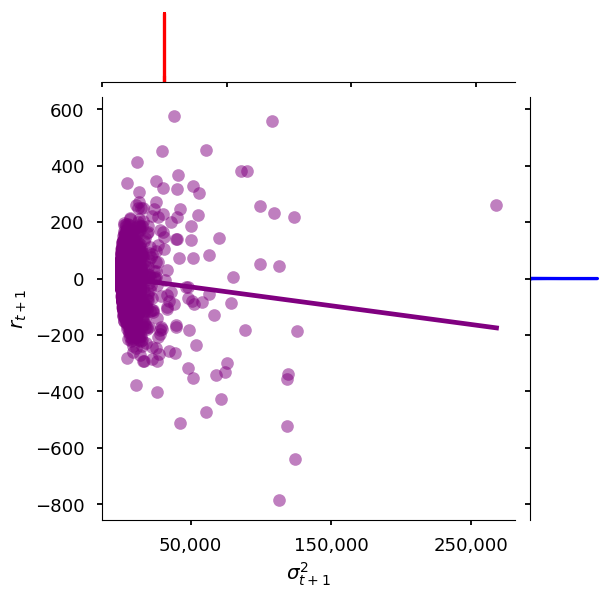

In [19]:
joint_grid = sns.JointGrid(x='vol', y='rtn', data=data_for_plot) #, xlim=[-.1, 3], ylim=[-2, 2])
joint_grid.plot_joint(sns.regplot, ci=None, color='purple', scatter_kws={"alpha":.5})
sns.kdeplot(data['vol'], ax=joint_grid.ax_marg_x, legend=None, shade=True, color='red')
sns.kdeplot(data['rtn'], ax=joint_grid.ax_marg_y, legend=None, shade=True, color='blue', vertical=True)
joint_grid.set_axis_labels("$\sigma^2_{t+1}$","$r_{t+1}$")
joint_grid.ax_marg_x.set_xticks(list(joint_grid.ax_marg_x.get_xticks())[::2])

joint_grid.ax_marg_x.set_xticklabels(["{:,.0f}".format(val) for val in joint_grid.ax_marg_x.get_xticks()])
joint_grid.savefig('../doc/figures/joint_dist.tmp.png', pad_inches=0, bbox_inches='tight')

In [20]:
data_for_plot.describe()

rtn            vol
count  5159.000000    5159.000000
mean      1.124584    3698.587740
std      66.941608    9098.226926
min    -785.436025      78.322546
25%     -25.205521     883.959361
50%       3.531094    1621.573582
75%      30.499981    3424.525309
max     574.802898  267911.173110

In [21]:
stats.kurtosis(data_for_plot, fisher=False)

array([ 16.806, 205.427])

In [22]:
stats.skew(data_for_plot)

array([-0.575, 11.246])

In [23]:
data_for_plot.corr()

rtn       vol
rtn  1.000000 -0.090481
vol -0.090481  1.000000

In [24]:
data.size**.5

101.57755657624375

In [25]:
mu1 = data.iloc[:int(data.size**.5)].mean()['vol']

In [26]:
def next_mu(omega_r, alpha_r, beta_r, previous_RV, previous_mu):
    return omega_r + alpha_r * previous_RV + beta_r * previous_mu

In [27]:
def compute_mu(omega_r, alpha_r, beta_r, RV, initial_mu):
    
    mu = [initial_mu]
    for vol in RV.iloc[:-1]:
        mu.append(next_mu(omega_r, alpha_r, beta_r, vol, mu[-1]))
        
    result = pd.DataFrame(mu, index=RV.index, columns=['mu'])
    
    return result

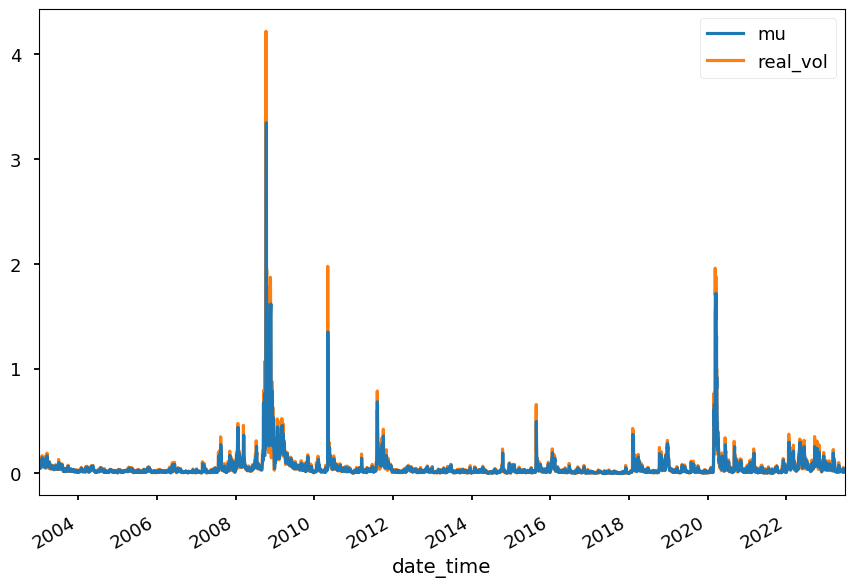

In [28]:
ax1 = compute_mu(0, .67, .31, data.vol, initial_mu=mu1).plot(zorder=2)
data.vol.plot(ax=ax1, label='real_vol', zorder=0)
ax1.legend()

Text(0.5, 0, '')

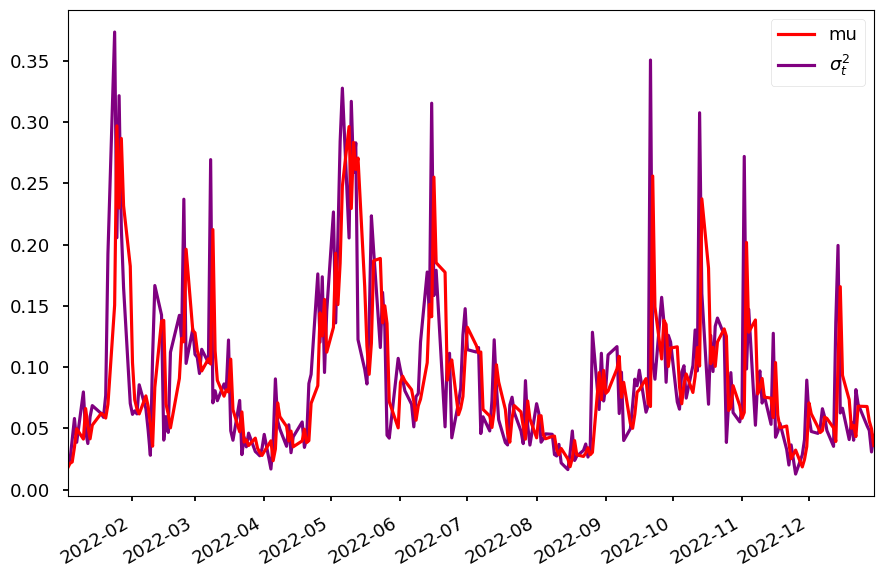

In [29]:
ax2 = compute_mu(0, .67, .31, data.vol, initial_mu=mu1).loc['2022'].plot(zorder=2, label='$\mut_t$', color='red')
data.vol.loc['2022'].plot(ax=ax2, label='$\sigma^2_t$', zorder=0, color='purple')
ax2.legend()
ax2.set_xlabel("")

In [30]:
def heavy_loss(params, vol=data.vol, initial_mu=mu1):
    
    omega_r, alpha_r, beta_r = params
    mu = compute_mu(omega_r, alpha_r, beta_r, vol, initial_mu=mu1)
    first_val =  np.log(mu.iloc[1:]).sum()
    second_val = (vol.T / mu.T).T.iloc[1:].sum()
    
    # We want to minimize this. 
    return .5 * ((first_val + second_val)).item()

In [31]:
omega_r, alpha_r, beta_r = (0.05, .5, .4)
mu = compute_mu(omega_r, alpha_r, beta_r, data.vol, initial_mu=mu1)
first_val =  np.log(mu.iloc[1:]).sum()
second_val = (data.vol.values / mu.values)[1:].sum()

In [32]:
results = optimize.minimize(heavy_loss, x0=(0, .8, .1))


In [33]:
results

      fun: -6250.659696201392
 hess_inv: array([[ 1.368e-07, -6.442e-06,  4.099e-07],
       [-6.442e-06,  5.258e-04, -1.941e-05],
       [ 4.099e-07, -1.941e-05,  1.320e-06]])
      jac: array([ 9.766e-04,  0.000e+00, -6.104e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 156
      nit: 13
     njev: 30
   status: 2
  success: False
        x: array([0.002, 0.669, 0.312])

In [34]:
data_for_saving = data.join(compute_mu(*results.x, RV=data.vol, initial_mu=mu1))

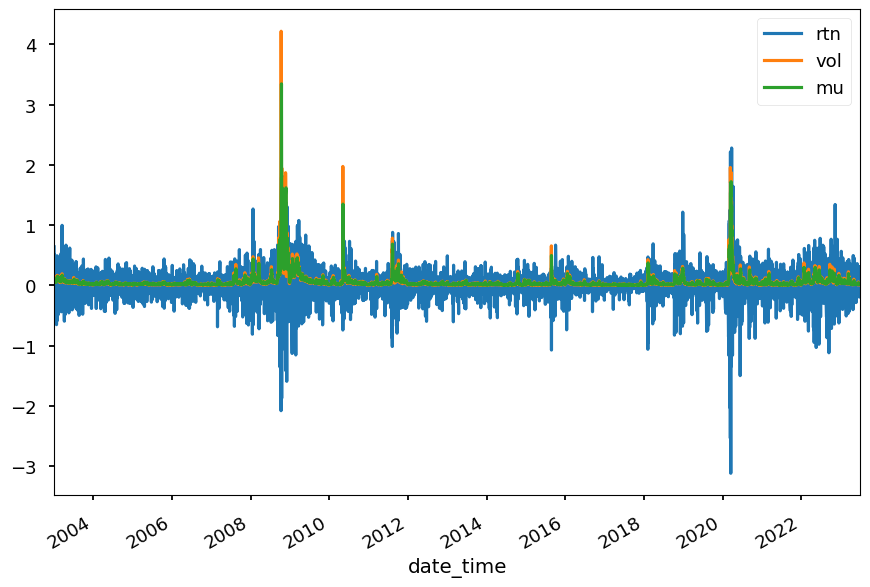

In [35]:
data_for_saving.plot()

In [36]:
data_for_saving.to_hdf('../data/spy_daily_estimates_heavy.hdf', key='data')

In [37]:
ls ../data

../data@


In [39]:
data.head()

rtn       vol
date_time                     
2003-01-02  0.641961  0.087998
2003-01-03  0.053996  0.077860
2003-01-06  0.515051  0.045863
2003-01-07 -0.089675  0.082945
2003-01-08 -0.274812  0.064468

In [40]:
data_for_saving.to_csv('../data/cheng_renault_sangrey_risk_price_data.csv')